## Transformations in Political Economy - Technological Change and Populism (POL63102)
### Coding Session 8: Differences in Differences (DiD)

---
This document guides you through coding session 8. Please try to follow the instructions on your own PC and feel free to ask questions if something is unclear. After this session you should be able to do the following:

- Implement Differences in Differences (DiD) in Python
- Interprete and visualize results of DiD and event study designs
---

## Recap: Theory

Differences in Differences aims to estimate the causal effect of treatment by comparing two differences: The change in outcome for the group receiving the treatment (red in the graph below) and the change in outcome for the control group (dark in the graph below). Under certain assumptions, the treatment effect $\gamma$ can be estimated.

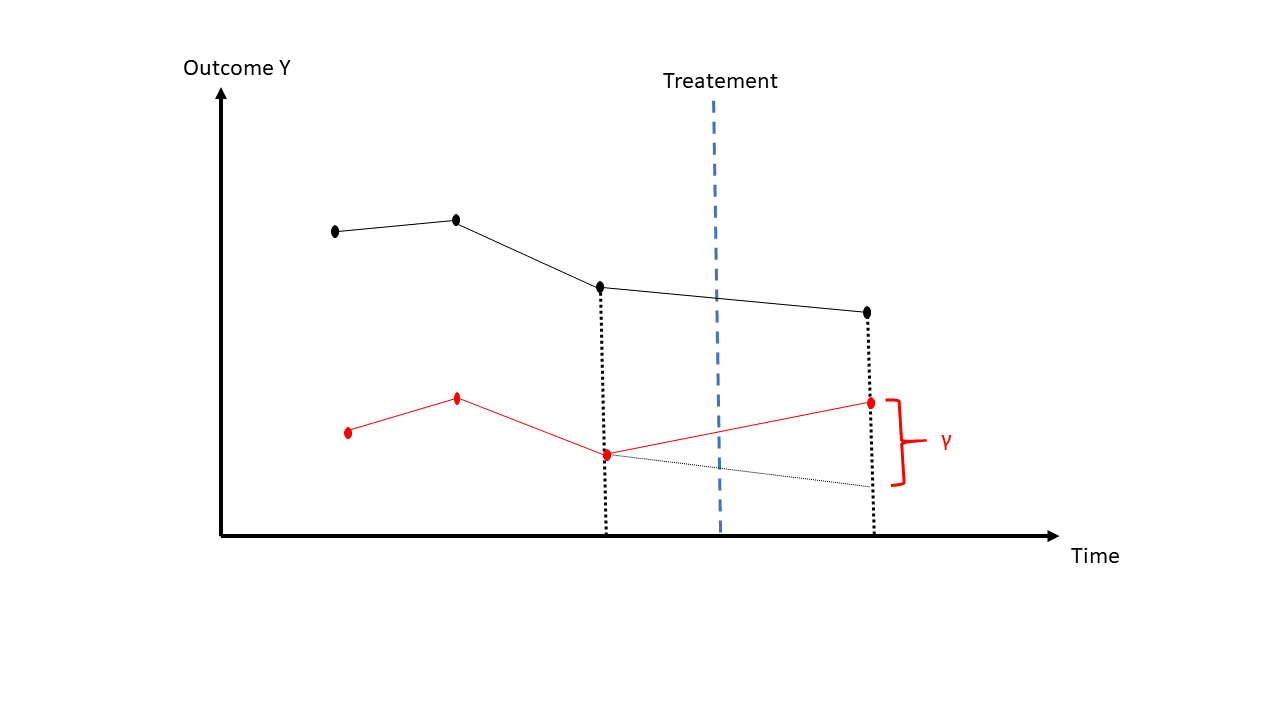

Remember that we can implement DiD in a regression model using an *interaction term*:

\begin{align*}
y_{it} = \beta_0 + \beta_1 Group_{i} + \beta_2 Post_{t} + \gamma (Group_{i} * Post_{t})_{it} + \epsilon_{it}
\end{align*}

where
- $y_{it}$ dependent variable varying at dimensions $i$ and $t$.
-  $Post_{t}$ is an indicator taking 1 after treatment, 0 before.
- $Group_{i}$ is an indicator for belonging to group red or black (in the figure above).
- $(Group_{i} * Post_{t})_{it}$ is the interaction term

The estimated coefficient on the interaction term, $\hat{\gamma}$, is the diff-in-diff estimate of the treatment effect.


Underlying assumptions are:
* Parallel trends
* No anticipation
* No spill-over

## Implementation

Let's create some hypothetical data with the following variables:

- **year** Years (2010, 2011, 2012)
- **id** Identifier (200 regions)
- **group** Dummy for treatment group (receiving some technological change)
- **populist_vote_share** Populist vote share

Don't worry about the details of simulating the data below, but have a look if you are interested.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# create a dataframe for each year of observations
df2010 = pd.DataFrame()
df2011 = pd.DataFrame()  
df2012 = pd.DataFrame()  

# use 200 observations per year
N =200

# set the seed for replicability
np.random.seed(seed=1234)

# create year variable
df2010["year"] = np.random.randint(2010,2011, size=N)
df2011["year"] = np.random.randint(2011,2012, size=N)
df2012["year"] = np.random.randint(2012,2013, size=N)

# create treatment group dummy (constant across time)
df2010["group"] = np.random.randint(0,2, size=N)
df2011["group"] = df2010["group"]
df2012["group"] = df2010["group"]

# create populist outcome variable
df2010["populist_vote_share"] = np.random.normal(0.2, 0.2, N).clip(0,1)
df2011["populist_vote_share"] = np.random.normal(0.2, 0.2, N).clip(0,1)

# simulate treatment effect for wave 2012
df2012["populist_vote_share"] = np.where(df2012['group']== 1, np.random.normal(0.4, 0.2, N),np.random.normal(0.2, 0.2, N)).clip(0,1)

# create index variable
df2010["id"] = df2010.index +1
df2011["id"] = df2010.index +1
df2012["id"] = df2010.index +1

# append data
df = df2010.append(df2011.append(df2012))

# order columns
df = df[['id', 'year', 'populist_vote_share', 'group']]


# sorting dataframe
df.sort_values(["id", "year"], inplace = True)

Let's have a first glance at the data:

In [2]:
df[0:15]

,id,year,populist_vote_share,group
0,1,2010,0.353474,1
0,1,2011,0.000000,1
0,1,2012,0.246792,1
1,2,2010,0.396984,1
1,2,2011,0.557596,1
1,2,2012,0.419976,1
2,3,2010,0.254167,0
2,3,2011,0.129098,0
2,3,2012,0.159928,0
3,4,2010,0.478397,1


## Does higher exposure to technological change lead to increase in populist vote shares?

Let's first look at the average trend in means of populist vote share for the treated group and the control group. Note that we make use of the *groupby()* and *mean()* functions here.

In [3]:
df.groupby(["group", "year"])[ "populist_vote_share"].mean()

group  year
0      2010    0.211514
       2011    0.203519
       2012    0.200797
1      2010    0.237527
       2011    0.218679
       2012    0.407792
Name: populist_vote_share, dtype: float64

**Exercise 1:** Manually calculate the simplest differences in differences estimate as follows. First, calculate the difference between the means in 2011 and 2012 populist vote shares for both control and treatment group. Second, take the difference of these two differences. Could you also calculate this estimate the other way around, that is first taking differences between groups, then between periods?

Let's visualise the difference in populist vote shares between the treatment and control groups over time:

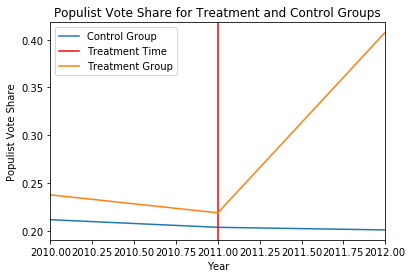

In [4]:
df_treated= df.query('group==1')
df_control= df.query('group==0')
df_control.groupby(["year"])["populist_vote_share"].mean().plot()
plt.axvline(x=2011, c='r')
df_treated.groupby(["year"])["populist_vote_share"].mean().plot()
plt.xlabel("Year")
plt.ylabel("Populist Vote Share")
plt.title("Populist Vote Share for Treatment and Control Groups")
plt.legend(('Control Group','Treatment Time','Treatment Group'))

The treatment group shows a higher mean after 2011, but this might be just pure chance.

To test whether technological change and populist vote share are causally related, we make use of our knowledge that **group 1 received a technology shock in 2012 that group 1 did not receive**.

As the name "differences in differences" suggests, there are two differences:
- Before/After Treatment (in our example 2012)
- Treatment/Control Group (in our example the *group* variable)

We already have a dummy variable for treatment/control group membership. Let's create a dummy variable for after treatment in 2012:

In [5]:
df["post"] =  (df["year"] >= 2012) 
df["post"].describe()

count       600
unique        2
top       False
freq        400
Name: post, dtype: object

## Difference in Difference 

We implement DiD using an interaction term between a dummy for after treatment and a dummy for treatment group.

In [6]:
import statsmodels.formula.api as smf
reg = smf.ols('populist_vote_share ~ group + post + group*post', data=df).fit(cov_type='HC1')
print(reg.summary())

                             OLS Regression Results                            
Dep. Variable:     populist_vote_share   R-squared:                       0.150
Model:                             OLS   Adj. R-squared:                  0.146
Method:                  Least Squares   F-statistic:                     28.35
Date:                 Fri, 16 Jul 2021   Prob (F-statistic):           3.79e-17
Time:                         10:20:53   Log-Likelihood:                 209.29
No. Observations:                  600   AIC:                            -410.6
Df Residuals:                      596   BIC:                            -393.0
Df Model:                            3                                         
Covariance Type:                   HC1                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.2

## Event Study Specification

First, we can combine DiD with Fixed Effects:

In [7]:
reg = smf.ols('populist_vote_share ~ group + post + group*post + C(year) + C(id)', data=df).fit(cov_type='HC1')
print(reg.summary())

                             OLS Regression Results                            
Dep. Variable:     populist_vote_share   R-squared:                       0.393
Model:                             OLS   Adj. R-squared:                  0.083
Method:                  Least Squares   F-statistic:                     49.30
Date:                 Fri, 16 Jul 2021   Prob (F-statistic):          2.18e-202
Time:                         10:20:53   Log-Likelihood:                 309.95
No. Observations:                  600   AIC:                            -213.9
Df Residuals:                      397   BIC:                             678.7
Df Model:                          202                                         
Covariance Type:                   HC1                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.2

C:\Users\felix\Anaconda3\lib\site-packages\statsmodels\base\model.py:1834: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 204, but rank is 203
  'rank is %d' % (J, J_), ValueWarning)


**Exercise 2:** What is the advantage of using fixed effects here? Why is there no change in the coefficient in this case?

Interacting treatment with year fixed effects gives us what is called an *event study specification*. Note that we use not only one interaction effect, but interact our treatment dummy with all time fixed effects, leaving out the period before treatment as reference category.
 

 \begin{align*}
y_{it} = \beta_0 + \sum_{k=T_0}^{-2} \gamma_k * Group_{i} + \sum_{k=0}^{T_1} \gamma_k * Group_{i} + \phi_t + \psi_i + \epsilon_{it}
\end{align*}


where
- $T_0$ and $T_1$ are the lowest and highest number of leads and lags to consider surrouning the treatment period, respectively.
- $\sum_{k=T_0}^{-2} \gamma_k * Group_{i}$ are interactions of treatment group with years before.
- $\sum_{k=0}^{T_1} \gamma_k * Group_{i}$ are interactions of treatment group with years after treatment.
- $\phi_t$ and $\psi_i$ time and individual fixed effects.

See https://lost-stats.github.io/Model_Estimation/Research_Design/event_study.html for an implementation in Python.

In [8]:
# create the lag/lead for treated observations
df['time_to_treat'] = df['year']-2012

# create time fixed effects variables in relation to treatment time
df = ( pd.get_dummies(df, columns=['time_to_treat'], prefix='INX')
      # Be sure not to include the minuses in the name
      .rename(columns=lambda x: x.replace('-', 'm'))
      # get_dummies has a `drop_first` argument, but if we want to
      # refer to a specific level, we should return all levels and
      # drop out reference column manually
      .drop(columns='INX_m1')
)

# Inspect
df[0:15]

,id,year,populist_vote_share,group,post,INX_m2,INX_0
0,1,2010,0.353474,1,False,1,0
0,1,2011,0.000000,1,False,0,0
0,1,2012,0.246792,1,True,0,1
1,2,2010,0.396984,1,False,1,0
1,2,2011,0.557596,1,False,0,0
1,2,2012,0.419976,1,True,0,1
2,3,2010,0.254167,0,False,1,0
2,3,2011,0.129098,0,False,0,0
2,3,2012,0.159928,0,True,0,1
3,4,2010,0.478397,1,False,1,0


In [9]:
# Run regression
reg = smf.ols('populist_vote_share ~ INX_m2 * group + INX_0 * group + C(year) + C(id)', data=df).fit(cov_type='HC1')
print(reg.summary())

                             OLS Regression Results                            
Dep. Variable:     populist_vote_share   R-squared:                       0.393
Model:                             OLS   Adj. R-squared:                  0.081
Method:                  Least Squares   F-statistic:                     41.71
Date:                 Fri, 16 Jul 2021   Prob (F-statistic):          1.17e-188
Time:                         10:20:53   Log-Likelihood:                 310.02
No. Observations:                  600   AIC:                            -212.0
Df Residuals:                      396   BIC:                             684.9
Df Model:                          203                                         
Covariance Type:                   HC1                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.1458      

strong multicollinearity problems or that the design matrix is singular.


C:\Users\felix\Anaconda3\lib\site-packages\statsmodels\base\model.py:1834: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 206, but rank is 204
  'rank is %d' % (J, J_), ValueWarning)


## Visualize Event Study

In [10]:
# Visualise
# get coefficients and CIs
output = pd.DataFrame(reg.summary().tables[1])
output.head()

,0,1,2,3,4,5,6
0,,coef,std err,z,P>|z|,[0.025,0.975]
1,Intercept,0.1458,0.007,20.691,0.000,0.132,0.160
2,C(year)[T.2011],0.0557,0.013,4.296,0.000,0.030,0.081
3,C(year)[T.2012],0.0265,0.008,3.206,0.001,0.010,0.043
4,C(id)[T.2],0.2581,0.141,1.835,0.067,-0.018,0.534


In [11]:
# Here are the interaction coefficients between group and time fixed effects:
output[205:208]

,0,1,2,3,4,5,6
205,INX_m2:group,0.0109,0.035,0.309,0.758,-0.058,0.080
206,INX_0,0.0265,0.008,3.206,0.001,0.010,0.043
207,INX_0:group,0.1918,0.036,5.294,0.000,0.121,0.263


In [12]:
res = pd.DataFrame()
res['coef']=[0.0109,0, 0.1918]
res['err']=[0.035,0, 0.036]
res['time_to_treat']=[-2,-1,0]
res['year']=[2010,2011,2012]
res

,coef,err,time_to_treat,year
0,0.0109,0.035,-2,2010
1,0.0000,0.000,-1,2011
2,0.1918,0.036,0,2012


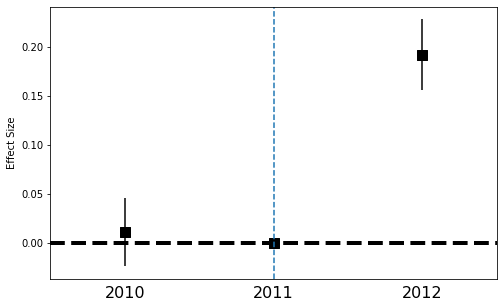

In [13]:
# Plot event study
fig, ax = plt.subplots(figsize=(8, 5))
res.plot(x='year', y='coef', kind='bar', 
             ax=ax, color='none', 
             yerr='err', legend=False)
ax.set_ylabel('Effect Size')
ax.set_xlabel('')
ax.scatter(x=pd.np.arange(res.shape[0]), 
           marker='s', s=120, 
           y=res['coef'], color='black')
ax.axhline(y=0, linestyle='--', color='black', linewidth=4)
ax.xaxis.set_ticks_position('none')
_ = ax.set_xticklabels(['2010','2011', '2012'], 
                       rotation=0, fontsize=16)
ax.axvline(1, linestyle='dashed')

---
**Congratulations! This is the end of coding session 8.**